## Temporal Fusion Transformer

# Import model and dataset

In [1]:
import os
import warnings
import copy
from pathlib import Path

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import multiprocessing
import torch
from pytorch_forecasting.metrics import RMSE, MAE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = np.load(r"D:\Study\Research-Lee 2024\Unilever\Unilever Data\Unprocessed panda\DEODORANT & FRAGRANCE_dataset.npz")

X = data['array_3d']  # Shape: (timestep, prediction_window, node, features)

In [3]:
X.shape

(180, 6884, 233)

In [4]:
# Reshape and convert data to pandas DataFrame
def to_dataframe(X, time_col='time_idx', node_col='node_id'):
    time_steps, nodes, features = X.shape
    data_list = []

    for t in range(time_steps):
        for n in range(nodes):
            row = {
                time_col: t,
                node_col: n,
                **{f'feature_{i}': X[t, n, i] for i in range(features)},
            }
            data_list.append(row)

    return pd.DataFrame(data_list)

df = to_dataframe(X)

In [6]:
df

,time_idx,node_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239115,179,6879,0.0,0.0,0.0,1.0,0.0,0.0,1.98,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239116,179,6880,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239117,179,6881,0.0,0.0,0.0,1.0,0.0,0.0,17.50,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1239118,179,6882,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Split data into train, validation, and test sets
def split_data(df, time_col, test_size=0.15, val_size=0.15):
    # Split the DataFrame into training and temporary sets
    train_df, temp_df = train_test_split(df, test_size=test_size + val_size, shuffle=False, stratify=None)
    # Split the temporary set into validation and test sets
    val_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + val_size), shuffle=False, stratify=None)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(df, time_col='time_idx')

In [5]:
print(train_df.shape)

(867384, 235)


In [6]:
val_df.shape

(185868, 235)

In [7]:
test_df.shape

(185868, 235)

# Dataloader construction

In [6]:
from sklearn.impute import SimpleImputer

# Define categorical and continuous features
categorical_features = ['node_id']
continuous_features = [f'feature_{i}' for i in range(1, X.shape[-1])]

def create_dataset(df, time_col, target_col, group_col, max_encoder_length, max_prediction_length):
    # Convert the group column to string type
    df[group_col] = df[group_col].astype(str)
    
    # Check for missing values
    print("Checking for missing values...")
    missing_summary = df.isna().sum()
    print(missing_summary[missing_summary > 0])

    # Handle missing values
    # Drop rows with missing target values
    df = df.dropna(subset=[target_col])
    
    # Fill missing values for features using mean imputation
    feature_cols = [col for col in df.columns if col.startswith('feature_') and col != "feature_0"]
    imputer = SimpleImputer(strategy='mean')
    df[feature_cols] = imputer.fit_transform(df[feature_cols])
    
    # Define categorical and continuous features
    static_categoricals = [group_col]
    time_varying_known_reals = feature_cols
    time_varying_unknown_reals = [target_col]
    
    return TimeSeriesDataSet(
        df,
        time_idx=time_col,
        target=target_col,
        group_ids=[group_col],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=static_categoricals,
        static_reals=[],  # No static real features in this example
        time_varying_known_categoricals=[],
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=time_varying_unknown_reals,
        allow_missing_timesteps=True
    )



# Set maximum lengths
max_encoder_length = 6  # Length of the historical data
max_prediction_length = 6  # Length of the forecast

train_dataset = create_dataset(train_df, time_col='time_idx', target_col='feature_0', group_col='node_id', max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length)
val_dataset = create_dataset(val_df, time_col='time_idx', target_col='feature_0', group_col='node_id', max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length)
test_dataset = create_dataset(test_df, time_col='time_idx', target_col='feature_0', group_col='node_id', max_encoder_length=max_encoder_length, max_prediction_length=max_prediction_length)

# Create DataLoaders
batch_size = 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

Checking for missing values...
feature_19     34027
feature_20     34027
feature_21     34027
feature_22     34027
feature_23     34027
               ...  
feature_222    34027
feature_226    34027
feature_227    34027
feature_229    34027
feature_232    34027
Length: 112, dtype: int64
Checking for missing values...
feature_19     14107
feature_20     14107
feature_21     14107
feature_22     14107
feature_23     14107
               ...  
feature_222    14107
feature_226    14107
feature_227    14107
feature_229    14107
feature_232    14107
Length: 112, dtype: int64
Checking for missing values...
feature_19     16115
feature_20     16115
feature_21     16115
feature_22     16115
feature_23     16115
               ...  
feature_222    16115
feature_226    16115
feature_227    16115
feature_229    16115
feature_232    16115
Length: 112, dtype: int64


# Model Implementation

In [7]:
# Check if GPU is available
if torch.cuda.is_available():
    device = 'cuda'
    print("GPU is available. Using GPU.")
else:
    device = 'cpu'
    print("GPU not available. Using CPU.")

GPU is available. Using GPU.


In [8]:
# Set float32 matrix multiplication precision
torch.set_float32_matmul_precision('medium')  # or 'high'

In [20]:
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cuda",
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.2,
    log_every_n_steps=10
)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.008,
    hidden_size=12,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=12,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
).to(device)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft):
        super().__init__()
        self.tft = tft

    def forward(self, x):
        return self.tft(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Extract prediction from tuple if necessary
        if isinstance(y_hat, tuple):
            y_hat = y_hat[0]

        loss = self.tft.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Ensure y_hat and y are tensors and not tuples, and have the correct shape
        if isinstance(y_hat, tuple):
            y_hat = y_hat[0]  # Assuming the first element of the tuple is the prediction
        if isinstance(y, tuple):
            y = y[0]  # Assuming the first element of the tuple is the target

        loss = self.tft.loss(y_hat, y)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return self.tft.configure_optimizers()

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 479.6k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.008317637711026716
Restoring states from the checkpoint path at d:\Study\Research-Lee 2024\Unilever\Transformer\.lr_find_bc08e6ee-3fab-4438-9ed6-8937a560a9e5.ckpt
Restored all states from the checkpoint at d:\Study\Research-Lee 2024\Unilever\Transformer\.lr_find_bc08e6ee-3fab-4438-9ed6-8937a560a9e5.ckpt


suggested learning rate: 0.008317637711026716


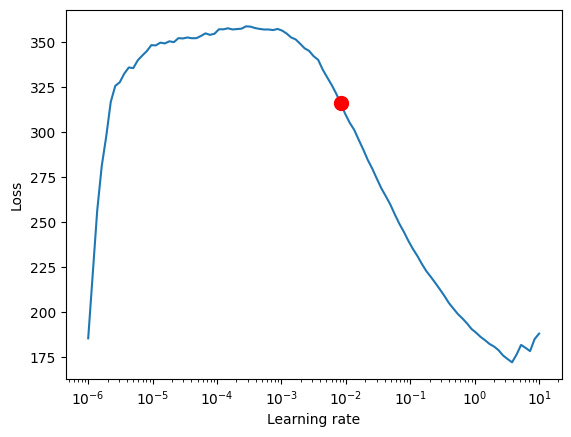

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26968\4268711780.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [14]:
# Create the LightningModule wrapper
tft_lightning = TFTLightningModule(tft)

# # Fit the LightningModule wrapper
trainer.fit(
    tft_lightning,  # Pass the LightningModule wrapper
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

model_save_path = "trained_unilever_tft_model.pth"
torch.save(tft.state_dict(), model_save_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                      | Params | Mode 
-----------------------------------------------------------
0 | tft  | TemporalFusionTransformer | 479 K  | train
-----------------------------------------------------------
479 K     Trainable params
0         Non-trainable params
479 K     Total params
1.918     Total estimated model params size (MB)
5035      Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Hyperparameter tuning

In [ ]:
# import pickle
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
#
# # Create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=5,
#     max_epochs=10,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=100),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )
#
# # Save study results - we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)
#
# # Show best hyperparameters
# print("Best hyperparameters:", study.best_trial.params)
#
# # Initialize the model with best hyperparameters
# best_trial = study.best_trial
# best_hparams = best_trial.params
#
# best_tft = TemporalFusionTransformer.from_dataset(
#     training,
#     hidden_size=best_hparams['hidden_size'],
#     dropout=best_hparams['dropout'],
#     hidden_continuous_size=int(best_hparams['hidden_continuous_size']),
#     attention_head_size=int(best_hparams['attention_head_size']),
#     learning_rate=best_hparams['learning_rate'],
#     loss=QuantileLoss(),
#     log_interval=10,  # Log every 10 batches
#     optimizer="Ranger",
#     reduce_on_plateau_patience=4,
# ).to(device)  # Move the model to GPU
#
# # Train with best hyperparameters
# trainer.fit(
#     TFTLightningModule(best_tft),  # Pass the LightningModule wrapper
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
# )

# model_save_path = "trained_best_tft_model.pth"
# # torch.save(tft.state_dict(), model_save_path)
# tft.load_state_dict(torch.load(model_save_path, map_location=device))
# calcualte mean absolute error on validation set

In [18]:
model_save_path = "trained_best_tft_model.pth"
torch.save(tft.state_dict(), model_save_path)
# tft.load_state_dict(torch.load(model_save_path, map_location=device))

AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [21]:
model_save_path = "trained_best_tft_model.pth"
tft.load_state_dict(torch.load(model_save_path, map_location=device))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26716\452137744.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tft.load_state_dict(torch.load(model_save_path, map_l

<All keys matched successfully>

In [26]:
# predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cuda"))
# print(f"RMSE{RMSE()(predictions.output, predictions.y)}")
# print("y = True")
# print(f"y: {predictions.y}")
# print(f"output: {predictions.output}")

# Make predictions on validation data
val_predictions = tft.predict(val_dataloader, return_index=True, mode="raw")
# Predictions on test data
test_predictions = tft.predict(test_dataloader, return_index=True, mode="raw")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [36]:
actual_val_targets = val_dataloader.dataset.data["target"]

In [39]:
print("Validation prediction")
print(val_predictions.output.prediction)
print("Validation target")
print(actual_val_targets)

Validation prediction
tensor([[[  1.7168,   2.7723,   2.3146,  ...,   0.6925,   3.9043,   5.4367],
         [  1.7195,   2.7847,   2.3201,  ...,   0.6955,   3.9341,   5.5801],
         [  1.7204,   2.7853,   2.3219,  ...,   0.6976,   3.9377,   5.5843],
         [  1.7214,   2.7858,   2.3234,  ...,   0.6984,   3.9395,   5.5849],
         [  1.7224,   2.7864,   2.3248,  ...,   0.6991,   3.9409,   5.5847],
         [  1.7233,   2.7869,   2.3259,  ...,   0.6993,   3.9416,   5.5840]],

        [[  1.7162,   2.7719,   2.3139,  ...,   0.6920,   3.9030,   5.4349],
         [  1.7197,   2.7850,   2.3205,  ...,   0.6958,   3.9344,   5.5803],
         [  1.7207,   2.7854,   2.3222,  ...,   0.6974,   3.9376,   5.5837],
         [  1.7217,   2.7860,   2.3238,  ...,   0.6985,   3.9398,   5.5848],
         [  1.7227,   2.7865,   2.3251,  ...,   0.6990,   3.9410,   5.5846],
         [  1.7237,   2.7870,   2.3263,  ...,   0.6991,   3.9417,   5.5836]],

        [[  1.7190,   2.7737,   2.3177,  ...,   0.